# Doubly Stochastic Variational Inference

## TO DO
* Wrap kernel in a function/class to allow $n \times n \times p$ covariances where $p$ is the number of hyperparameter samples. USE A NEW SPARSEGP CLASS, copy all the code from SparseGPReg and implement the varying of the hyperparameters
* Test SparseGPReg on a $R^2 \to R$ and/or $R^3 \to R$ function.
* Start to implement an online learning version of fit; split the fit function into a function for a single batch and a wrapper around to iterate over that. Then can reuse a _single_batch_fit function into online learning.

## Remember
* Discussion needs to reference the other literature

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import gpflow
from gpflow.config import default_float
from sklearn.cluster import KMeans

In [2]:
class GPBase:
    """ Base for Gaussian Process
    
    Includes plotting functions and options for setting X, Y to new values. Also includes template for functions which need implementing."""
    def __init__(self, X, Y, kernel, gaussian_noise = 0.0):
        self.X = tf.Variable(X, dtype = default_float())
        self.N = len(X)
        self.Y = tf.Variable(Y, dtype = default_float())
        self.kernel = kernel
        self.gaussian_noise = gaussian_noise
    
    def predict(self, X_star):
        pass
    
    def log_likelihood(self):
        pass
    
    def optimise(self):
        pass
    
    def setData(self, X = None, Y = None):
        if X is not None:
            self.X = X
        if Y is not None:
            self.Y = Y
        assert X.shape[0] == Y.shape[0], "X, Y should have the same first dimension"
    
    def plot(self, figsize = None):
        xrange = np.arange(tf.math.reduce_min(self.X), tf.math.reduce_max(self.X), 0.1)
        xrange = xrange.reshape(-1, 1)
        mu, var = self.predict(xrange)
        mu = tf.reshape(mu, [-1])
        var = tf.reshape(var, [-1])
        dist = tfd.Normal(mu, tf.sqrt(var))
        lower_bound = dist.quantile(0.025)
        upper_bound = dist.quantile(0.975)
        if figsize is not None:
            assert len(figsize) == 2 and type(figsize) is tuple
            plt.figure(figsize = figsize)
        plt.plot(xrange, mu, label = 'mean')
        plt.fill_between(xrange.reshape(-1), lower_bound, upper_bound, alpha = 0.2, label = '95% confidence interval')
        plt.scatter(self.X, self.Y, label = 'data')
        plt.legend()
        plt.show()

In [3]:
class GPReg(GPBase):
    """
    Class describing a simple Gaussian Process Regression
    
    parameters:
        X, Y: two vectors (NxD) and (1xD) of  corresponding X and Y observations.
        kernel: a gpflow covariance function
        gaussian_noise: the gaussian noise in the observations: default 0.0
    """
    def __init__(self, X, Y, kernel, gaussian_noise = 0.0):
        super().__init__(X, Y, kernel, gaussian_noise)
        
    def predict(self, X_star, full_covariance = False):
        """
        Returns the predicted mean and variance of f at each point in X_star
        
        Args:
            X_star: the locations to predict at, shape (NxD)
            full_covariance: whether to return the full predicted covariance or just the diagonal
            
        Returns:
            (mean, variance) tuple where the ith entry of each is the predicted mean and variance for the ith point in X_star.
            If full_covariance is true returns the predicted covariance matrix of X_star instead.
        """
        X_star = tf.Variable(X_star, dtype = default_float())
        self.Kxx = self.kernel.K(self.X, self.X)
        self.InvKxxI = tf.linalg.inv(self.Kxx + self.gaussian_noise * tf.eye(self.N, dtype = default_float()))
        self.Kxsx = self.kernel.K(X_star, self.X)
        self.Kxsxs = self.kernel.K(X_star, X_star)
        self.kxxs = self.kernel.K(self.X, X_star)
        
        mu = self.Kxsx @ self.InvKxxI @ self.Y
        sig = self.Kxsxs - self.Kxsx @ self.InvKxxI @ self.kxxs
        if full_covariance:
            return mu, sig
        else:
            var = tf.linalg.diag_part(sig)
            var = tf.reshape(var, [-1, 1])
            return mu, var
    
    def log_likelihood(self, ):
        return - 
    
    def optimise(self, iterations, lr):
        

### Simple example data
Noiseless GP on a sin curve.

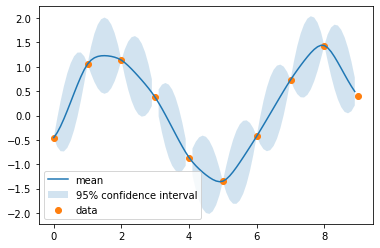

In [23]:
X = np.arange(0, 10).reshape(-1, 1)
Y = np.sin(X) + 0.2 * np.random.normal(0, 1, size = (len(X), 1))
m = GPReg(X, Y, gpflow.kernels.Matern32(1))
X_star = np.array([[1.2], [5.6]])
m.plot()

In [24]:
gpflow.kernels.RBF(1)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,1


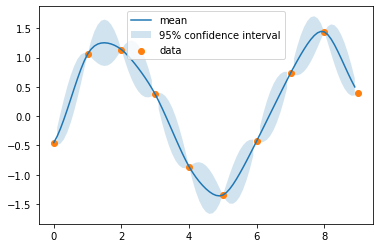

In [27]:
m.kernel.lengthscales.assign(1.2)
m.kernel.variance.assign(0.4)
m.gaussian_noise = 0.0
m.plot()

### Variational sparse GP

In [4]:
def get_cov(mat):
    """
    Takes a lower triangular matrix and returns a positive semi-definite matrix.
    
    Args:
        mat: a lower triangular matrix (tf 2D Tensor)
        
    Returns:
        positive semi-definite matrix, i.e. a valid covariance matrix.
    """
    return mat @ tf.transpose(mat)

In [5]:
class SparseGPReg(GPBase):
    """
    Variationally Sparse GP
    
    Args:
        X, Y: the data we are inferring from, arrays of shape (n, d) and (n, 1) respectively.
        Z: the inducing points (an m x d array) or the number of inducing points (int)
    """
    def __init__(self, X, Y, Z, kernel, gaussian_noise = 0.0):
        super().__init__(X, Y, kernel, gaussian_noise)
        if type(Z) == int:
            self.place_inducing(Z)
        else:
            self.Z = tf.Variable(Z, dtype = default_float())
        
        self.num_inducing = self.Z.shape[0]
        # We want to randomly initialise mu and scale for q(u)
        # scale is a lower triangular matrix ensures the cov is positive semi-definite;
        # we then get the full cov by scale @ scale.T
        self.mu = np.random.normal(0, 0.2, size = (len(Z), 1))
        self.scale = np.random.normal(0, 0.08, size = (len(Z), len(Z)))
        self.scale = np.tril(self.scale)
        
        self.mu = tf.Variable(self.mu, dtype = default_float())
        self.scale = tf.Variable(self.scale, dtype = default_float())
        self.likelihood_var = 0.01
            
    def fit(self, batch_size, epochs, lr, fit_Z = False):
        """
        Optimizes the variational mean and scale parameters, and the inducing points (optionally).
        
        Uses Adam optimisation to maximise the ELBO (minimise the negative ELBO).
        
        Args:
            batch_size: the number of datapoints to use at each step.
            epochs: the number of times the whole dataset is iterated over.
            lr: the learning rate of the optimiser.
            fit_z: whether to train the positions of the inducing points (default: False).

        Returns:
            None
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
        ratio = self.X.shape[0]/batch_size

        for epoch in range(epochs):
            batches = self._batchdata(batch_size)
            for batch_X, batch_Y in batches:
                with tf.GradientTape() as tape:
                    # Could we sample the hyperparameters at this point?
                    # Since we are iterating over the data multiple times, 
                    # just use a different hp combination for each batch sampled from a MVN?
                    # Seems like it would be faster but not very mathematically sound?
                    elbo_loss = 0

                    # Approximate E_(q_f)[log(Y|f)]
                    q_f_mu, q_f_cov = self.predict(batch_X, full_covariance = True) # Get mu and cov from prediction
                    q_f = tfd.MultivariateNormalFullCovariance(q_f_mu, q_f_cov) # Define q(f)
                    f = q_f.sample(1000) # Sample f from q(f)
                    p_y_f = tfd.Normal(f, self.likelihood_var) # STUCK HERE: Not sure what value to use for variance.
                    E_log_y_f = tf.math.reduce_mean(p_y_f.log_prob(batch_Y))
                    elbo_loss -= ratio * E_log_y_f
                    
                    # Get KL[q(u)||p(u)]
                    q_u = tfd.MultivariateNormalFullCovariance(self.mu, get_cov(self.scale))

                    p_u_mu = tf.zeros([1, self.num_inducing], dtype = default_float())
                    p_u_cov = self.kernel.K(self.Z, self.Z)
                    p_u = tfd.MultivariateNormalFullCovariance(p_u_mu, p_u_cov)

                    kl_q_u_p_u = tfd.kl_divergence(q_u, p_u)
                    elbo_loss += tf.math.reduce_mean(kl_q_u_p_u)

                to_update = [self.mu, self.scale]
                if fit_Z:
                    to_update.append(self.Z)
                gradients = tape.gradient(elbo_loss, to_update)
                print(gradients)
                optimizer.apply_gradients(zip(gradients, to_update))
                
            if epoch % 10 == 0:
                print(f'{epoch}/{epochs}: elbo loss = {elbo_loss}')
    
    def predict(self, X_star, full_covariance = False):
        """
        The predicted mean and variance of each point in X_star.
        
        Args:
            X_star: the points to make a prediction at.
            full_covariance: whether to return a single variance value for each X_star or a full covariance 
            matrix on X_star.
        
        Returns:
            tuple (mu, var) where mu and var are arrays representing the predicted mean and variance respectively
            at each X_star. If full_covariance then var is a covariance matrix on X_star.
        """
        Kxsz = self.kernel.K(X_star, self.Z)
        Kzz = self.kernel.K(self.Z, self.Z)
        InvKzz = tf.linalg.inv(Kzz + self.gaussian_noise * tf.eye(self.num_inducing, dtype = default_float()))
        Kxsxs = self.kernel.K(X_star, X_star)
        Kzxs = self.kernel.K(self.Z, X_star)
        
        mu = Kxsz @ InvKzz @ self.mu
        sig = Kxsxs - Kxsz @ InvKzz @ Kzxs + Kxsz @ InvKzz @ get_cov(self.scale) @ InvKzz @ Kzxs
        if full_covariance:
            return mu, sig
        else:
            var = tf.linalg.diag_part(sig)
            return mu, var
    
    def _batchdata(self, batch_size):
        """
        Batches the data into an iterator, randomly shuffling the order."""
        num_batches = self.X.shape[0]//batch_size
        
        indices = np.arange(0, self.Y.shape[0])
        np.random.shuffle(indices)
        indices = tf.convert_to_tensor(indices, tf.dtypes.int64)
        X = tf.gather(self.X, indices)
        Y = tf.gather(self.Y, indices)
        
        batches = []
        for i in range(num_batches):
            start, end = i*batch_size-1, (i+1)*batch_size-1
            batches.append((X[start:end], Y[start:end]))
        return iter(batches)
    
    def log_likelihood(self, theta):
        pass
    
    def plot(self, figsize = None):
        Z_points = np.array(self.Z).reshape(-1)
        y = np.zeros(self.Z.shape[0])
        plt.figure(figsize = figsize)
        plt.scatter(Z_points, y, c = 'black', marker = '+', label = 'Inducing Point Locations')
        super().plot()
        
    def place_inducing(self, Z):
        """
        Places Z inducing points around the d-dimensional space containing X using K-means clustering.
        Args:
            Z: the number of inducing points we want to initialise.
        """
        N, D = self.X.shape
        datapoints = np.array(self.X)
        kmeans = KMeans(n_clusters=Z).fit(datapoints)
        Z = tf.kmeans.cluster_centers_
        self.Z = tf.Variable(Z, dtype = default_float())
        return Z

In [6]:
Z = np.arange(0, 10, 2).reshape(-1, 1)
sgpr = SparseGPReg(X, Y, Z, gpflow.kernels.RBF(1), 0.005)
sgpr.plot(figsize=(18, 10))

NameError: name 'X' is not defined

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-1.24125417],
       [-0.15432137],
       [ 1.3447041 ],
       [-1.18170905],
       [-1.40913612]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-8.92812001e+00, -3.04772839e+00, -4.62650214e+01,
        -5.34435725e+02, -2.28981370e+03],
       [ 8.00108207e-02,  1.50857422e+01,  1.77245138e+02,
         1.83120095e+03,  7.72225457e+03],
       [ 4.31175861e-02,  4.38697537e-01,  1.40532613e+02,
         1.15036429e+03,  4.65990624e+03],
       [-1.12360659e-01, -3.40674126e-01, -1.28324195e-01,
        -3.58667322e+02, -1.64414147e+03],
       [-1.78832878e-01, -5.11385243e-01,  3.54199143e-01,
        -3.67706812e-01, -6.24725825e+01]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-4.44588547e-02],
       [ 6.61410277e-03],
       [ 8.34569638e-05],
       [-9.46017175e-03],
       [ 4.72214667e-02]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 3.14912066e+00],
       [-7.15339562e+

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.17416614],
       [ 1.75197945],
       [-0.65081717],
       [-1.20067009],
       [ 0.74858888]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-31.1441317 ,   7.50622061, -11.58406114,   4.11873094,
         -2.26083094],
       [-15.80812069,   8.71383113,  -4.31619821,   8.94289312,
         -0.56204313],
       [-15.20194045, -18.3286841 , -18.96848656,   1.31499439,
         -8.11498809],
       [ -1.48318506, -28.77956533, -22.09434141,  15.93307473,
        -16.77816907],
       [-21.22584784,   7.10416723, -62.82669577,   9.28607968,
        -13.02779439]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-0.00574152],
       [-0.11374629],
       [ 0.09764183],
       [ 0.01446506],
       [ 0.00738092]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -712.85337946],
       [-4045.71872963],
       [  -80.15485084],
       [ 2467.20761575],
       [   10.59989221]])>, <tf.Tensor: sh

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.93026707],
       [ 3.54131351],
       [-1.22356698],
       [-2.51992531],
       [ 2.30176263]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ -3.71010095, -33.89114902,  20.70297843, -32.05726479,
         -8.06891692],
       [-12.33907108, -20.61969831,   3.28158722, -22.18414722,
          3.01333597],
       [ 12.75563556,  34.80613249,  20.79390858,  36.10848029,
         -0.6302045 ],
       [ 23.70926792,  14.59729819,   0.4735745 ,  41.45216674,
         10.17558897],
       [  2.25283337, -71.33555628, -13.42105518, -80.2744031 ,
         -5.19974124]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-0.33803533],
       [ 0.04704773],
       [ 0.01884966],
       [ 0.23154463],
       [ 0.04059331]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  716.52730835],
       [-1218.87971961],
       [  -44.53775437],
       [  116.14738178],
       [-1368.36984212]])>, <tf.Tensor: sh

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-459.45827947],
       [-476.1549815 ],
       [ -86.31276008],
       [ -70.17163992],
       [-901.7616776 ]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 150.83513501,  -50.68318043, -156.08395034,   10.03573892,
        -190.67537094],
       [  17.59393298,   -3.05618979,    1.02353303,  -12.22378604,
         -63.5634495 ],
       [ -53.21166273,  -69.42939453, -108.35102921,  -33.38518791,
          83.95085584],
       [  12.89524268,  -13.21666472,  -18.17220113,   26.32408053,
          28.36771294],
       [  30.30179949,   35.20546243,   -9.53631004,  -67.07808433,
          12.8827717 ]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 181.40561224],
       [ 808.25074292],
       [-253.33232552],
       [  59.89536092],
       [  74.60325921]])>]
20/100: elbo loss = 857.2312681099672
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.64293799],
       [ 4.46657845],
       [-1.2854

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -1.69453974],
       [-44.11690843],
       [148.31984558],
       [127.71500421],
       [249.92493001]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[  13.66113222,   10.15023092,   21.05432956,    9.74931825,
           8.69933194],
       [  -0.26456414,  -16.52089016,  -78.35484124,   40.1140157 ,
          10.42515155],
       [ -16.11713551,  -40.44570703, -187.63034691,   62.97867214,
         149.59187299],
       [  60.8636741 ,  -29.84637698,  -41.28763719,   -5.13943488,
          -7.62852084],
       [   7.86655354, -106.88117252,   39.86260239,    3.44046728,
          12.68325285]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -15.81076784],
       [-285.67877195],
       [ 249.34732036],
       [-565.11011802],
       [ 134.4246971 ]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 1.02142966],
       [ 4.83342329],
       [-1.31196419],
       [-3.91771929],
       [ 4.459

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  -1.77114734],
       [  23.4662646 ],
       [ -66.86736557],
       [-630.36607489],
       [ -61.39104835]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 3.07661453e+01,  1.88962879e+01,  9.27637843e-01,
        -1.61476335e+01,  5.61562313e-01],
       [ 7.21976857e-01, -1.92581236e+01,  7.91268848e+01,
         9.28550023e+01, -5.11078475e+00],
       [-2.08680342e+00, -1.04630367e+01,  3.19647128e+01,
        -2.28964058e+01,  3.24770490e+01],
       [ 7.03959606e+01, -2.02114493e+02,  6.79692025e+01,
        -7.85773861e+01,  2.72052333e+01],
       [-2.03189655e+01, -2.14420371e+01,  1.00302113e+01,
        -2.90059707e+01, -1.65685456e-01]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -13.715095  ],
       [-243.6094619 ],
       [-431.99478405],
       [ 614.49652993],
       [ 567.96357564]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.91508401],
       [ 5.01481871],
   

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[361.03730938],
       [-26.81727076],
       [ -4.90743922],
       [ 39.36890463],
       [-62.82219982]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-62.09564143,  73.72860676,  66.95162355,  43.31689963,
        -64.84302341],
       [-22.64836839,   3.15003423,  -3.52562326, -27.64688834,
         29.02710603],
       [ 65.09371275, -27.50807465,  18.56446817, -11.90690015,
         30.53167449],
       [-13.01724463, -62.86872729,  49.0904175 ,  35.82242187,
         36.69134901],
       [ -9.61958636, -44.82193584,  89.18648266, -24.34487036,
        -19.13104681]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  93.32861099],
       [  78.96925205],
       [-314.46793509],
       [-414.47896537],
       [-601.51248168]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.70452503],
       [ 5.28303095],
       [-1.21332592],
       [-3.72298531],
       [ 4.7322753 ]])>, <tf.Tensor: sh

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  53.80963788],
       [-160.96557456],
       [  94.76829019],
       [ 252.62386601],
       [-110.67667245]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-169.55088889,  191.77867803,  387.42867964,  450.19209246,
         -70.74401164],
       [ -24.75308092,   15.51345019,   64.01263866,   65.83929065,
         -57.96780635],
       [-203.15012012,  147.58265828,  220.30572012,  190.41481624,
          37.97348515],
       [ -24.00768966,   31.90059008, -124.96369674,  -59.36473627,
          34.98289077],
       [  39.20954007,   56.7971584 ,   11.29227878,  -18.95294914,
         -22.51732102]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  53.38681517],
       [ 428.70061723],
       [-326.13407978],
       [ 468.34622508],
       [-268.79204829]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.43342397],
       [ 5.29700737],
       [-1.28692294],
       [-3.63497909],
       [ 

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-79.06180886],
       [ -4.23155401],
       [  5.20611659],
       [150.92682487],
       [ -7.86791619]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 3.78799512e+01,  2.15546132e+00,  4.80396239e+01,
         8.37979586e+01,  1.56233491e+01],
       [ 2.89653949e+01, -2.53404002e+01, -5.49970169e+01,
        -2.59689483e+01, -1.15620408e+01],
       [-1.59276605e+01, -2.45136069e+01, -6.28727385e+00,
         9.26511377e+00,  4.24282917e-02],
       [-1.64289912e+01,  1.23618068e+01,  1.09547688e+02,
         1.80989371e+02, -9.34629813e+01],
       [ 7.14853633e+00,  1.55354463e+02,  2.81981052e+02,
         2.49212904e+02, -3.41634597e+02]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-136.46543271],
       [ 120.44728925],
       [ -15.85571908],
       [-171.03023116],
       [ 321.77908017]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.2514775 ],
       [ 5.32068377],
       [

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-162.03684047],
       [  12.47702343],
       [  30.14307251],
       [-191.68822243],
       [-146.23061658]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-6.64193415e+01,  1.10627930e+02, -1.57169129e+01,
        -2.56038852e+01, -1.89741924e+01],
       [-3.11873062e+02,  5.75475920e+02,  2.18298097e+01,
        -1.04777394e+02, -1.66463277e+02],
       [-2.24524137e+01, -2.35349357e-01,  1.44070492e+01,
        -2.84325499e+01, -1.16032976e+01],
       [-1.98335210e+02, -2.45757967e+02,  8.92991247e+01,
        -2.17811416e+02, -7.91019517e+00],
       [-1.13868324e+01, -1.88549645e+01,  2.24570214e+00,
        -1.82718170e+01, -8.79491803e+00]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-133.98122621],
       [ 346.77259453],
       [ -10.49313305],
       [ 130.67749856],
       [-191.96211423]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.10334016],
       [ 5.43566487],
   

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-138.59567743],
       [ -94.83341806],
       [  23.34073803],
       [  90.10208408],
       [ 138.10875858]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[  48.98714878, -720.25223011,  -69.90045698, -360.11708684,
         281.74179018],
       [ -46.43066692,  -15.01611927, -136.24922606,  107.46343451,
         -20.33395532],
       [   7.3192833 ,  -47.40236622,   61.5011745 ,  -74.2272481 ,
          58.5579489 ],
       [  85.32523602, -251.46090421,  304.31190032, -447.27321353,
         346.59903278],
       [-183.97079884,  623.56561828, -240.77630627,  402.46035588,
        -539.85047287]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[135.20132974],
       [315.56426692],
       [-42.12228329],
       [317.9150109 ],
       [258.06328852]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.19725267],
       [ 5.33002866],
       [-1.14101778],
       [-3.71653239],
       [ 4.643

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 11.4895093 ],
       [ 65.36600791],
       [ 83.52075414],
       [212.79491964],
       [-44.56042337]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[   6.56132519,   24.21528115,   60.35865398,  -19.46754867,
         -21.56221581],
       [ -38.92887556, -153.6308452 ,  217.23038177,   -5.51953788,
        -156.95232536],
       [ -35.00846748,   98.45071067,   20.6242773 ,   30.96152539,
          -7.58700072],
       [ -34.25515285,   80.3896659 ,  -51.25057043,   78.95812428,
          63.66190871],
       [  -7.83135963,   11.44587616,  -19.35780348,   21.11842856,
          11.14399619]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-201.87778706],
       [-118.58472764],
       [-323.22269536],
       [-504.74834019],
       [-370.34075178]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.49582798],
       [ 5.35719633],
       [-0.74005394],
       [-3.78721573],
       [ 4.571

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -22.50800791],
       [ 157.54191822],
       [ 116.05571418],
       [-150.23788194],
       [ 261.67095855]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[-6.17198418e+00,  1.37049190e+01, -1.55999751e-01,
         1.84626011e+01,  2.48303725e+01],
       [ 6.13068982e+00, -8.58296822e+01, -3.09150464e+01,
        -1.68831855e+02, -2.36481966e+01],
       [ 1.78757613e+01, -6.13031189e+01,  9.03778536e+01,
        -5.61488591e+01,  1.28300913e+01],
       [-1.14058770e+02, -1.27280505e+02,  2.34352689e+01,
        -2.99915294e+01, -1.78848853e+01],
       [-4.28029513e+01,  1.65844846e+02, -8.80733237e+01,
         6.67686752e+01, -8.74564758e+00]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[   1.01796779],
       [-227.37578523],
       [ 448.25617589],
       [ 240.37805445],
       [-421.47305737]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.69296488],
       [ 5.36027453],
   

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  -4.98781354],
       [  46.33011692],
       [ 186.377679  ],
       [ -32.03612391],
       [-338.1027454 ]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ -11.88994049,    7.87396606,   -3.206263  ,   10.44179472,
          44.10879097],
       [ -13.5158207 ,   25.13995268,   19.97748639,   -6.21254937,
         -11.70469673],
       [-130.31237319,  204.65138596,  129.22652541,    3.33024771,
         -93.24376156],
       [ -74.71724688,  124.73878793, -198.60014752,   23.97121015,
         -67.8964549 ],
       [-167.53684836,   93.95905421, -184.46925634,   81.79986774,
         -77.93806727]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  1.04542465],
       [  4.68141971],
       [ 94.41406016],
       [ 12.59553748],
       [708.75602391]])>]
90/100: elbo loss = 703.8813857771677
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.19032222],
       [ 5.40981644],
       [-0.8810684 ]

[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[  5.19478883],
       [-50.89429428],
       [-59.61168746],
       [-21.32224671],
       [-58.86456953]])>, <tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[  18.18522142,   -0.89915095,  -12.76185048,    3.52406881,
          -6.56184523],
       [-120.68293327,   34.46585212,   23.64532157,   63.59892937,
         -34.58816441],
       [  15.80901261,  -16.64816565,   21.40282231,  -38.3685981 ,
         -47.74988372],
       [  26.01437112,    1.65121594,   66.07706965,  -48.02769456,
         -84.77201093],
       [ 430.86722124, -217.93960855,  200.11334457,   -6.85089399,
           5.85711577]])>, <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ -13.97109952],
       [-336.03830267],
       [-394.79633225],
       [ 436.61187256],
       [ 244.15810082]])>]
[<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.04128672],
       [ 5.32962029],
       [-0.97410666],
       [-3.86779985],
       [ 4.498

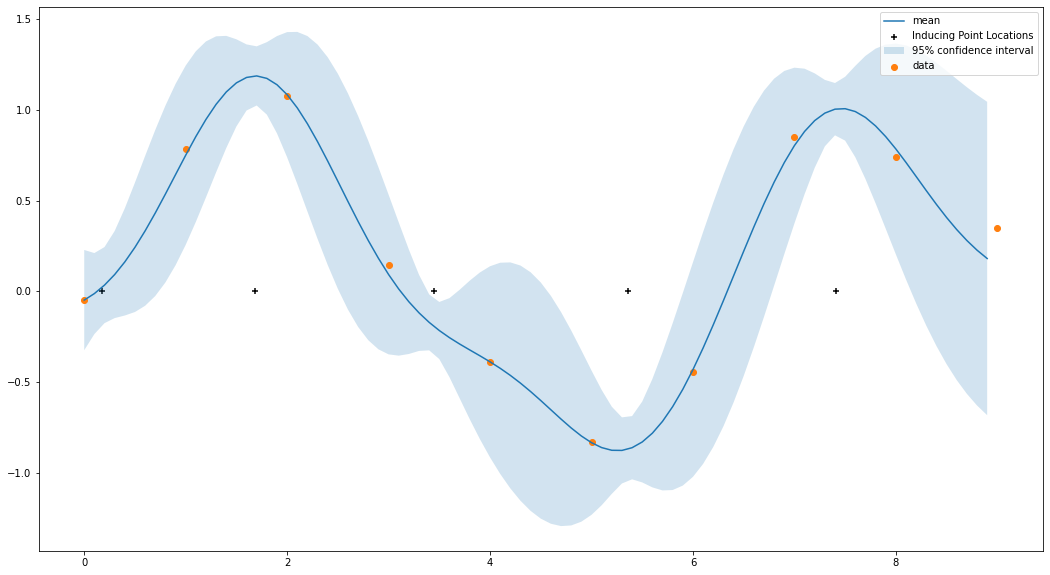

In [114]:
sgpr = SparseGPReg(X, Y, Z, gpflow.kernels.RBF(1), 0.005)
sgpr.kernel.lengthscales.assign(0.8)
sgpr.kernel.variance.assign(0.2)
sgpr.fit(batch_size = 5, epochs = 100, lr = 0.05, fit_Z=True)
sgpr.plot(figsize=(18, 10))

### Variational sparse GP with hyperparameter marginalisation

In [221]:
class VariKernel:
    def __init__(self, gpflow_k, param_names):
        self.gpflow_k = gpflow_k
        self.param_names = param_names
    
    def K(X1, X2, param_samples = None):
        """
        Returns the covariance of K given each set of hyperparameters.
        
        Args:
            X1, X2: the two tensors between which the covariance is found.
            param_samples: a 2D tensor of shape(n_samples, n_parameters).
            The order of the hyperparameters should match the order of the original param_list
        
        Returns:
            an (N x L1 x L2) tensor where N is the number of hyperparameter samples and Li is the length of Xi.
            The [i,:,:] 2D tensor is K(X1, X2|theta i); the covariance of X1 and X2 for the ith hyperparameter configuration.
        """
        original_vals = self.get_param_dict()
        if param_samples is None:
            _sample_params(1)
        elif type(param_samples) == int:
            _sample_params(param_samples)

        K_list = []
        p_samples_list = tf.unstack(param_samples)
        for param_comb in p_samples_list:
            self.set_param_tensor(param_comb)
            Kxx_theta = self.gpflow_k.K(X1, X2)
            K_list.append(Kxx_theta)
        return tf.stack(K_list)
    
    def _sample_params(self, num):
        """TO DO"""
        tfd.MultivariateNormalDiag(self.get_param_dict.values)
        raise NotImplemented
        
    def get_param_dict(self):
        params = {param: float(getattr(self.gpflow_k, param).numpy()) for param in self.param_names}
        return params
    
    def get_param_tensor(self):
        np_params = np.array(list(self.get_param_dict().values()))
        return tf.Variable(np_params, dtype = default_float())
    
    def set_param_dict(self, param_dict):
        for param_name, param_value in param_dict.items():
            param = getattr(self.gpflow_k, param_name)
            param.assign(param_value)
    
    def set_param_tensor(self, param_tensor):
        p_dict = {p_name: p_value for p_name, p_value in zip(param_names, param_tensor)}
        self.set_param_dict(p_dict)

In [222]:
gpflow_kernel = gpflow.kernels.Matern52(2)
param_list = ['lengthscales', 'variance']

k = VariKernel(gpflow_kernel, param_list)
k.get_param_dict()

new_ps = {'lengthscales': 3.0, 'variance': 2.5}
k.set_param_dict(new_ps)
k.get_param_tensor()

<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([3. , 2.5])>